In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, random_split
import torchmetrics
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2 as cv
from datetime import datetime

import os
import segmentation_models_pytorch as smp

A:\Jupyter Files\envs\visual\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Data prep

In [3]:
JSON_FILE = r"HuBMAP dataset\polygons.jsonl"
IMG_PATH = r"HuBMAP dataset\imgs"
TILE_META_PATH = r"HuBMAP dataset\tile_meta.csv"

SEED = 42

In [5]:
class TileNineByNine(Dataset):
    
    def __init__(self, json_file=JSON_FILE,
                 images_path=IMG_PATH,
                 tile_meta_path=TILE_META_PATH,
                 wsi_n=1,
                 test=False):

        self.test = test
        self.wsi_n = wsi_n
        self.tile_meta = tile_meta_path
        self.polygons = json_file
        self.images_path = images_path

    def __len__(self):
        return len(self.polygons)

    @property
    def tile_meta(self):
        return self.__tile_meta

    @tile_meta.setter
    def tile_meta(self, val):
        with open(val) as f:
            tile_file = pd.read_csv(f)
            if self.test:
                tile_file = tile_file[tile_file.source_wsi == self.wsi_n].reset_index(drop=True)
            else:
                tile_file = tile_file[tile_file.source_wsi.isin([n for n in [1,2,3,4] if n!=self.wsi_n])].reset_index(drop=True)
            self.__tile_meta = tile_file

    @property
    def polygons(self):
        return self.__polygons

    @polygons.setter
    def polygons(self, val):
        with open(val) as f:
            polygons = pd.read_json(f, lines=True)
            polygons = polygons[polygons.id.isin(self.tile_meta.id)].reset_index(drop=True)
            self.__polygons = polygons
    
    def transformation(self, image, mask):
        
        need_crop = (image.shape[0] > 512)
        
        image = Image.fromarray(image)
        mask_img = Image.fromarray(mask)
        
        rotate_params = np.random.choice([0.0, 90.0, 180.0, 270.0, 0.0])
#         rotate_params = transforms.RandomRotation.get_params((-60, 60))
                
        flip = np.random.random()

        flip_v = np.random.random()

        jitter = np.random.random()
            
        if jitter > 0.5:
            image = transforms.ColorJitter(brightness=.5, hue=.3)(image)
            
        image = TF.rotate(image,rotate_params)
            
        if flip > 0.7:
            image = TF.hflip(image)
            
        if flip_v > 0.7:
            image = TF.vflip(image)       
        
        mask_img = TF.rotate(mask_img,rotate_params)
                
        if flip > 0.7:
            mask_img = TF.hflip(mask_img)
                
        if flip_v > 0.7:
            mask_img = TF.vflip(mask_img)
        
        input_image_size = (512, 512)
        
        if need_crop:
            crop_size = np.random.choice(range(412, 812)) #1530
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])            
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)
        
        else:
            crop_size = np.random.choice(range(412, 512)) #1530
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])            
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)

        mask = (np.array(mask_img))           
            
        return (image, mask)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        img_name = self.polygons.iloc[index, 0]                              
        
        image = Image.open(os.path.join(self.images_path, img_name)+'.tif')
        
        image_large = np.zeros((512*3, 512*3, 3), dtype=np.uint8)
        mask_large = np.zeros((512*3, 512*3), dtype=np.uint8)

        n_wsi = self.tile_meta.source_wsi[self.tile_meta.id == img_name].item()

        self.df_wsi = self.tile_meta[self.tile_meta.source_wsi == n_wsi]
        
        col_coord, row_coord = self.df_wsi.i[self.tile_meta.id == img_name].item(), \
        self.tile_meta.j[self.tile_meta.id == img_name].item()

        init_row = row_coord - 512

        is_blank_flag = False

        y = 0
        for i in range(3):
            x=0
            init_col = col_coord - 512

            for j in range(3):
                
                image_small_name = self.df_wsi.id[np.logical_and((self.df_wsi.i == init_col),
                                                                    (self.df_wsi.j == init_row))]

                if image_small_name.empty or self.test:
                    is_blank_flag = True
                    image_large = np.array(image)
                    
                    mask_large = np.zeros((512, 512), dtype=np.uint8)
                    
                    for coord_dict in self.polygons.annotations[index]:
                        if coord_dict['type'] == 'blood_vessel':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=1)
        
                        if coord_dict['type'] == 'glomerulus':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=2)
                        
                    break

                image_small_path = os.path.join(self.images_path, image_small_name.item() + '.tif')
                
                with Image.open(image_small_path) as image_small:
                    image_large[y:y+512,x:x+512,:] = np.array(image_small)
                
                index_mask = self.polygons.index[self.polygons.id == image_small_name.item()].item()

                mask = np.zeros((512, 512), dtype=np.uint8)
                
                for coord_dict in self.polygons.annotations[index_mask]:
                    if coord_dict['type'] == 'blood_vessel':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=1)
        
                    if coord_dict['type'] == 'glomerulus':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=2)
                    
                mask_large[y:y+512,x:x+512] = mask   
                
                x += 512
                init_col += 512
                
            if is_blank_flag:
                break
            y += 512
            init_row += 512
            
        if not self.test:
            image_large, mask_large = self.transformation(image_large, mask_large)
        
        image_large = np.array(image_large).transpose((2, 0, 1))
        if image_large.max():
            image_large = image_large/image_large.max()
        
        image_large = norm(torch.tensor(image_large.astype(np.float32)))
        
        return image_large, mask_large.astype(np.float32)

In [5]:
# dataset = TileNineByNine(test=True, wsi_n=2)

In [6]:
def show_masked(img, mask):
#     img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     print(img.shape, mask.shape)
    mask_full = np.zeros_like(img, dtype=np.uint8)
    mask_full[:,:,0] = mask
    masked_img = cv.bitwise_or(img, mask_full)
    
    return(masked_img)
    
def img_denorm(x: np.ndarray) -> np.ndarray:
    """
    :param: normalized image with transforms.Normilize
    :return: numpy array with values 0 to 255
    """
    x = x + np.abs(x.min())
    x = x/x.max()
    x = x * 255
    x = x.astype(np.uint8)
    
    return x

In [7]:
train_set = TileNineByNine()
test_set = TileNineByNine(test=True)

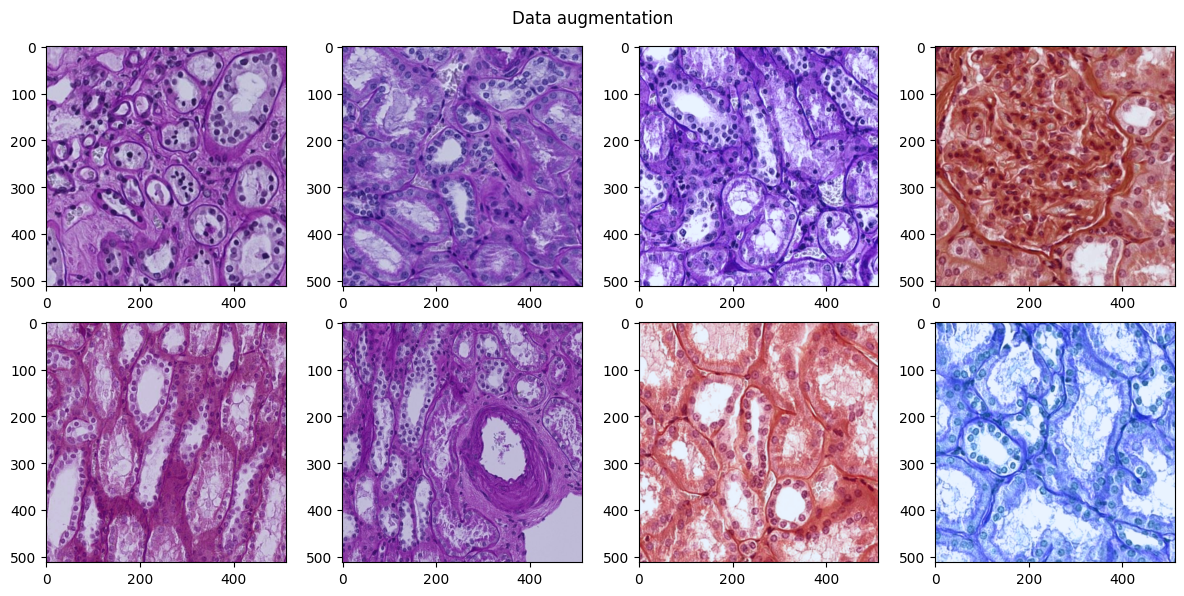

In [8]:
plot_row = 2
plot_col = 4

fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,6), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        r_num = np.random.randint(0, len(train_set))

        image = train_set[r_num][0]
        image = image.numpy().transpose((1,2,0))
        image = img_denorm(image)

        axs[i, j].imshow(image)

fig.suptitle('Data augmentation')
plt.show()

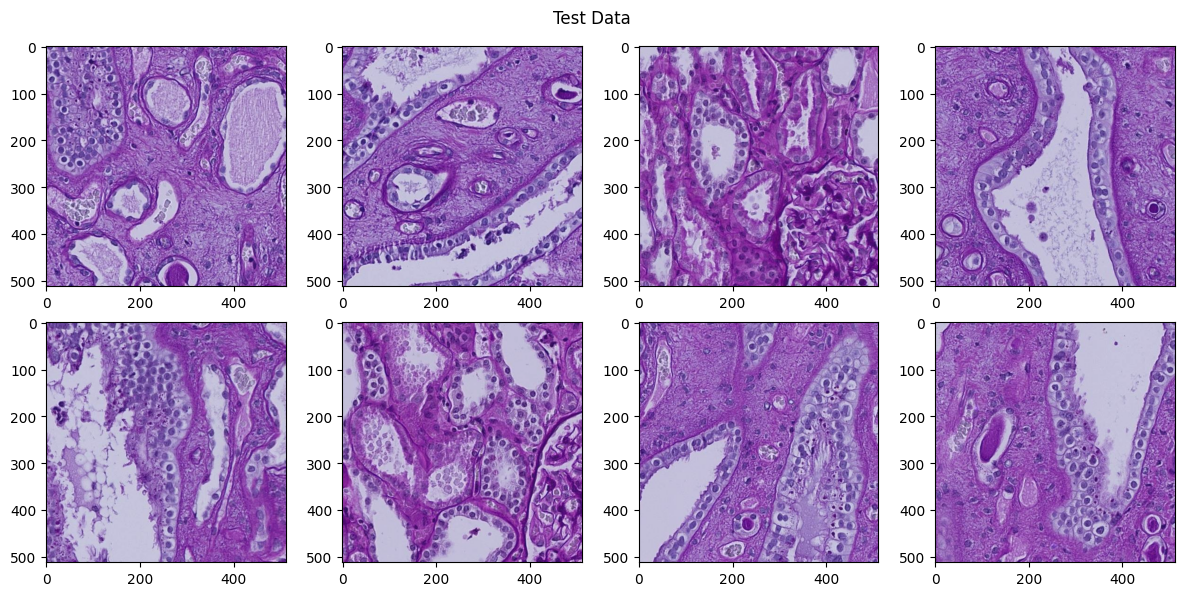

In [9]:
plot_row = 2
plot_col = 4

fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,6), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        r_num = np.random.randint(0, len(test_set))

        image = test_set[r_num][0]
        image = image.numpy().transpose((1,2,0))
        image = img_denorm(image)

        axs[i, j].imshow(image)

fig.suptitle('Test Data')
plt.show()

In [10]:
# fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,6), layout='tight')
#
# for i in range(plot_row):
#     for j in range(plot_col):
#         r_num = np.random.randint(0, len(dataset))
#
#         img, msk = dataset[r_num]
#         img, msk = img.numpy().transpose((1,2,0)), msk
#         img, msk = img_denorm(img), msk.astype(np.uint8)
#         mask_classes = np.zeros((512, 512, 2), dtype=np.uint8)
#         mask_classes[:,:,0] = (msk==1)
#         mask_classes[:,:,1] = (msk>1)
#
#         if mask_classes.max():
#             mask_classes = mask_classes*(255//mask_classes.max())
#
#         img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
#
#         bnw_img = np.stack((img,)*3, axis=-1)
#         bnw_img[:,:,0] = cv.bitwise_or(bnw_img[:,:,0], mask_classes[:,:,0])
#         bnw_img[:,:,2] = cv.bitwise_or(bnw_img[:,:,2], mask_classes[:,:,1])
#
#         axs[i, j].imshow(bnw_img, cmap='gray')
#
# fig.suptitle('Masked images, red - target class "blood vessels"')
# plt.show()

In [11]:
# for img, msk in train_loader:
#     # print(msk.shape, img.shape)
#     image = img[0]
#     img, msk = img[0], msk[0]
#     img, msk = img.numpy().transpose((1,2,0)), msk.numpy()
#     img, msk = img_denorm(img), msk.astype(np.uint8)
#     if msk.max():
#         msk = msk*(255//msk.max())
#     # print(img.dtype, msk.max())
#
#     plt.imshow(show_masked(img, msk))
#     break

## MODEL and training

In [7]:
def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """

    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))

    return average_array

def init_dataloaders(wsi_n, batch_size):

    train_data = TileNineByNine(test=False, wsi_n=wsi_n)
    test_data = TileNineByNine(test=True, wsi_n=wsi_n)

    train_len = int(len(train_data)*0.9)
    train_dev_len = len(train_data) - train_len

    train_data, train_dev_data = random_split(train_data, [train_len, train_dev_len])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    train_dev_loader = DataLoader(train_dev_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

    return train_loader, test_loader, train_dev_loader

def train_model(model, loss_func_focal, loss_func_dice, n_epochs, lr, wd, gamma, wsi_n):

    best_score = 0
    best_epoch = 0
    warmup_steps = 7

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma, verbose=True)
    warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 2e-02, 1, warmup_steps, verbose=True)
    scaler = torch.cuda.amp.GradScaler()
    model.to(device)

    losses_train = np.zeros(n_epochs)
    losses_test = np.zeros(n_epochs)
    losses_train_dev = np.zeros(n_epochs)

    iou_test = np.zeros(n_epochs)
    iou_train_dev = np.zeros(n_epochs)
    iou_all = np.zeros(n_epochs)

    for i in range(n_epochs):
        model.train()
        losses_epoch_train = []

        t0 = datetime.now()

        for inputs, targets in tqdm(train_loader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs)
                loss = 0.7*loss_func_dice(outputs, targets) + loss_func_focal(outputs, targets)
                # loss = loss_func(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)

            scaler.update()

            losses_epoch_train.append(loss.item())

        if i < warmup_steps:
            warmup_scheduler.step()
        else:
            lr_scheduler.step()

        losses_test[i], iou_test[i], losses_train_dev[i],\
        iou_train_dev[i], iou_all[i] = test_model(model, loss_func_focal, loss_func_dice)

        losses_train[i] = np.mean(losses_epoch_train)

        if iou_test[i] == np.max(iou_test[:i+1]):
            torch.save(model.state_dict(), r'models\cv\best__wsi{}.pt'.format(wsi_n))
            best_score = iou_test[i]
            best_epoch = i
            print(f'Best saved, IoU: {iou_test[i]:.3f}')

        if n_epochs > 100 and i == 100:
            torch.save(model.state_dict(), '100_epochs__.pt')
            print(f'100 epochs weights saved!')

        dt = datetime.now() - t0

        print(f'WSI #{wsi_n}, Epoch: {i+1}/{n_epochs}')
        print(f'Train loss: {losses_train[i]:.3f} Test loss: {losses_test[i]:.3f}, Train-dev loss: {losses_train_dev[i]:.3f}')
        print(f'Time: {dt}, IoU 1 class test: {iou_test[i]:.3f}, IoU train-dev: {iou_train_dev[i]:.3f}')
        print(f'IoU all classes test: {iou_all[i]:.3f}')
        torch.cuda.empty_cache()

        train_res = {'losses_train': losses_train, 'losses_test': losses_test,
                     'losses_train_dev': losses_train_dev, 'iou_test': iou_test,
                     'iou_train_dev': iou_train_dev, 'iou_all': iou_all,
                     'best_score': best_score, 'best_epoch': best_epoch}

    return train_res

def test_model(model, loss_func_focal, loss_func_dice):

    metrics_all_classes = torchmetrics.JaccardIndex(task='multiclass', num_classes=3)
    metrics = torchmetrics.JaccardIndex(task='binary')

    metrics.to(device)
    metrics_all_classes.to(device)

    losses_epoch_test = []
    iou = []
    iou_all_classes = []
    iou_2class_test = []

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()

            outputs = model(inputs)
            loss = 0.7*loss_func_dice(outputs, targets) + loss_func_focal(outputs, targets)
            # loss = loss_func(outputs, targets)

            zrs = np.zeros(targets.shape, dtype=np.float32)
            zrs[targets.cpu().numpy()==1] = 1
            zrs = torch.tensor(zrs).to(device)

            zrs_2 = np.zeros(targets.shape, dtype=np.float32)
            zrs_2[targets.cpu().numpy()==2] = 1
            zrs_2 = torch.tensor(zrs_2).to(device)

            iou.append(metrics(outputs[:,1,:,:], zrs).item())
            iou_2class_test.append(metrics(outputs[:,2,:,:], zrs_2).item())
            iou_all_classes.append(metrics_all_classes(outputs, targets).item())

            losses_epoch_test.append(loss.item())

    losses_train_dev = []
    iou_train_dev = []

    with torch.no_grad():
        for inputs, targets in tqdm(train_dev_loader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()

            outputs = model(inputs)
            # loss = loss_func(outputs, targets)
            loss = 0.7*loss_func_dice(outputs, targets) + loss_func_focal(outputs, targets)

            zrs = np.zeros(targets.shape, dtype=np.float32)
            zrs[targets.cpu().numpy()==1] = 1
            zrs = torch.tensor(zrs).to(device)

            iou_train_dev.append(metrics(outputs[:,1,:,:], zrs).item())
            losses_train_dev.append(loss.item())

    return np.mean(losses_epoch_test), np.nanmean(iou), np.mean(losses_train_dev),\
           np.nanmean(iou_train_dev), np.nanmean(iou_all_classes)

def axis_loss_set(ax, train_res):

    ax.plot(train_res['losses_test'], label='test')
    ax.plot(moving_average(train_res['losses_test']), label='m/a_test')
    ax.plot(train_res['losses_train'], label='train')
    ax.plot(moving_average(train_res['losses_train']), label='m/a_train')

    ax.plot(train_res['losses_train_dev'], label='train-dev', linestyle='dotted')

    ax.set_title(f"#{WSI}, scr:{train_res['losses_test'][-1]:.4f}', loc='left")
    ax.legend()

    return ax

def axis_iou_set(ax, train_res, score):

    ax.plot(train_res['iou_test'], label='test')
    ax.plot(moving_average(train_res['iou_test']), label='m/a_iou')
    ax.plot(train_res['iou_train_dev'], label='train-dev', linestyle='dotted')
    ax.plot(train_res['iou_all'], label='all cls')
    ax.scatter(train_res['best_epoch'], train_res['best_score'], label='max', color='r')

    ax.set_title(f"#{WSI}, scr:{score:.4f}, best:{train_res['best_score']:.4f}", loc='left')
    ax.legend()

    return ax

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-06.


100%|██████████| 213/213 [02:42<00:00,  1.31it/s]


Adjusting learning rate of group 0 to 1.6000e-05.


100%|██████████| 23/23 [00:14<00:00,  1.59it/s]


Best saved, IoU: 0.059
WSI #2, Epoch: 1/80
Train loss: 1.216 Test loss: 1.164, Train-dev loss: 1.175
Time: 0:03:14.646160, IoU 1 class test: 0.059, IoU train-dev: 0.041
IoU all classes test: 0.198


100%|██████████| 213/213 [02:32<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 3.0000e-05.


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


WSI #2, Epoch: 2/80
Train loss: 1.042 Test loss: 1.010, Train-dev loss: 1.025
Time: 0:03:10.709139, IoU 1 class test: 0.015, IoU train-dev: 0.014
IoU all classes test: 0.326


100%|██████████| 213/213 [02:36<00:00,  1.37it/s]


Adjusting learning rate of group 0 to 4.4000e-05.


100%|██████████| 23/23 [00:14<00:00,  1.58it/s]


WSI #2, Epoch: 3/80
Train loss: 0.935 Test loss: 0.895, Train-dev loss: 0.876
Time: 0:03:14.592059, IoU 1 class test: 0.006, IoU train-dev: 0.014
IoU all classes test: 0.450


100%|██████████| 213/213 [02:36<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 5.8000e-05.


100%|██████████| 23/23 [00:14<00:00,  1.54it/s]


WSI #2, Epoch: 4/80
Train loss: 0.894 Test loss: 0.899, Train-dev loss: 0.871
Time: 0:03:14.249027, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.441


100%|██████████| 213/213 [02:30<00:00,  1.42it/s]


Adjusting learning rate of group 0 to 7.2000e-05.


100%|██████████| 23/23 [00:16<00:00,  1.43it/s]


WSI #2, Epoch: 5/80
Train loss: 0.874 Test loss: 0.861, Train-dev loss: 0.859
Time: 0:03:11.227472, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.524


100%|██████████| 213/213 [02:36<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 8.6000e-05.


100%|██████████| 23/23 [00:16<00:00,  1.41it/s]


WSI #2, Epoch: 6/80
Train loss: 0.871 Test loss: 0.845, Train-dev loss: 0.853
Time: 0:03:20.083988, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.512


100%|██████████| 213/213 [02:36<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


WSI #2, Epoch: 7/80
Train loss: 0.865 Test loss: 0.854, Train-dev loss: 0.842
Time: 0:03:16.869253, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.522


100%|██████████| 213/213 [02:34<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 9.9000e-05.


100%|██████████| 23/23 [00:17<00:00,  1.34it/s]


WSI #2, Epoch: 8/80
Train loss: 0.859 Test loss: 0.853, Train-dev loss: 0.855
Time: 0:03:18.976141, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.554


100%|██████████| 213/213 [02:34<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 9.8010e-05.


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


WSI #2, Epoch: 9/80
Train loss: 0.847 Test loss: 0.844, Train-dev loss: 0.817
Time: 0:03:17.117664, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.546


100%|██████████| 213/213 [02:30<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 9.7030e-05.


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


WSI #2, Epoch: 10/80
Train loss: 0.844 Test loss: 0.836, Train-dev loss: 0.850
Time: 0:03:14.966104, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.552


100%|██████████| 213/213 [02:31<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 9.6060e-05.


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Best saved, IoU: 0.183
WSI #2, Epoch: 11/80
Train loss: 0.840 Test loss: 0.836, Train-dev loss: 0.829
Time: 0:03:14.196900, IoU 1 class test: 0.183, IoU train-dev: 0.281
IoU all classes test: 0.577


100%|██████████| 213/213 [02:33<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 9.5099e-05.


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


Best saved, IoU: 0.289
WSI #2, Epoch: 12/80
Train loss: 0.842 Test loss: 0.819, Train-dev loss: 0.822
Time: 0:03:18.200647, IoU 1 class test: 0.289, IoU train-dev: 0.331
IoU all classes test: 0.661


100%|██████████| 213/213 [02:31<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 9.4148e-05.


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]


WSI #2, Epoch: 13/80
Train loss: 0.827 Test loss: 0.830, Train-dev loss: 0.810
Time: 0:03:15.500127, IoU 1 class test: 0.275, IoU train-dev: 0.363
IoU all classes test: 0.674


100%|██████████| 213/213 [02:33<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 9.3207e-05.


100%|██████████| 23/23 [00:17<00:00,  1.34it/s]


Best saved, IoU: 0.313
WSI #2, Epoch: 14/80
Train loss: 0.829 Test loss: 0.825, Train-dev loss: 0.812
Time: 0:03:17.938080, IoU 1 class test: 0.313, IoU train-dev: 0.353
IoU all classes test: 0.660


100%|██████████| 213/213 [02:29<00:00,  1.42it/s]


Adjusting learning rate of group 0 to 9.2274e-05.


100%|██████████| 23/23 [00:16<00:00,  1.36it/s]


WSI #2, Epoch: 15/80
Train loss: 0.825 Test loss: 0.819, Train-dev loss: 0.807
Time: 0:03:13.543881, IoU 1 class test: 0.310, IoU train-dev: 0.411
IoU all classes test: 0.674


100%|██████████| 213/213 [02:33<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 9.1352e-05.


100%|██████████| 23/23 [00:17<00:00,  1.29it/s]


WSI #2, Epoch: 16/80
Train loss: 0.818 Test loss: 0.830, Train-dev loss: 0.783
Time: 0:03:18.267052, IoU 1 class test: 0.297, IoU train-dev: 0.440
IoU all classes test: 0.619


100%|██████████| 213/213 [02:28<00:00,  1.43it/s]


Adjusting learning rate of group 0 to 9.0438e-05.


100%|██████████| 23/23 [00:16<00:00,  1.41it/s]


WSI #2, Epoch: 17/80
Train loss: 0.824 Test loss: 0.836, Train-dev loss: 0.794
Time: 0:03:12.010318, IoU 1 class test: 0.304, IoU train-dev: 0.432
IoU all classes test: 0.682


100%|██████████| 213/213 [02:31<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 8.9534e-05.


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


Best saved, IoU: 0.324
WSI #2, Epoch: 18/80
Train loss: 0.829 Test loss: 0.808, Train-dev loss: 0.821
Time: 0:03:16.506731, IoU 1 class test: 0.324, IoU train-dev: 0.466
IoU all classes test: 0.675


100%|██████████| 213/213 [02:30<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 8.8638e-05.


100%|██████████| 23/23 [00:16<00:00,  1.40it/s]


WSI #2, Epoch: 19/80
Train loss: 0.826 Test loss: 0.838, Train-dev loss: 0.781
Time: 0:03:11.769794, IoU 1 class test: 0.291, IoU train-dev: 0.478
IoU all classes test: 0.678


100%|██████████| 213/213 [02:31<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 8.7752e-05.


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]


Best saved, IoU: 0.330
WSI #2, Epoch: 20/80
Train loss: 0.818 Test loss: 0.830, Train-dev loss: 0.806
Time: 0:03:15.798788, IoU 1 class test: 0.330, IoU train-dev: 0.488
IoU all classes test: 0.696


100%|██████████| 213/213 [02:32<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 8.6875e-05.


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


Best saved, IoU: 0.350
WSI #2, Epoch: 21/80
Train loss: 0.824 Test loss: 0.822, Train-dev loss: 0.791
Time: 0:03:16.963462, IoU 1 class test: 0.350, IoU train-dev: 0.457
IoU all classes test: 0.696


100%|██████████| 213/213 [02:36<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 8.6006e-05.


100%|██████████| 23/23 [00:15<00:00,  1.45it/s]


WSI #2, Epoch: 22/80
Train loss: 0.819 Test loss: 0.815, Train-dev loss: 0.769
Time: 0:03:20.139612, IoU 1 class test: 0.338, IoU train-dev: 0.489
IoU all classes test: 0.699


100%|██████████| 213/213 [02:34<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 8.5146e-05.


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


Best saved, IoU: 0.353
WSI #2, Epoch: 23/80
Train loss: 0.825 Test loss: 0.817, Train-dev loss: 0.799
Time: 0:03:20.063722, IoU 1 class test: 0.353, IoU train-dev: 0.433
IoU all classes test: 0.708


100%|██████████| 213/213 [02:36<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 8.4294e-05.


100%|██████████| 23/23 [00:18<00:00,  1.27it/s]


WSI #2, Epoch: 24/80
Train loss: 0.829 Test loss: 0.823, Train-dev loss: 0.815
Time: 0:03:23.597932, IoU 1 class test: 0.334, IoU train-dev: 0.528
IoU all classes test: 0.692


100%|██████████| 213/213 [02:48<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 8.3451e-05.


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


WSI #2, Epoch: 25/80
Train loss: 0.816 Test loss: 0.821, Train-dev loss: 0.799
Time: 0:03:34.224201, IoU 1 class test: 0.341, IoU train-dev: 0.449
IoU all classes test: 0.675


100%|██████████| 213/213 [02:53<00:00,  1.23it/s]


Adjusting learning rate of group 0 to 8.2617e-05.


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]


Best saved, IoU: 0.359
WSI #2, Epoch: 26/80
Train loss: 0.818 Test loss: 0.821, Train-dev loss: 0.792
Time: 0:03:38.993882, IoU 1 class test: 0.359, IoU train-dev: 0.487
IoU all classes test: 0.707


100%|██████████| 213/213 [02:45<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 8.1791e-05.


100%|██████████| 23/23 [00:17<00:00,  1.30it/s]


WSI #2, Epoch: 27/80
Train loss: 0.821 Test loss: 0.817, Train-dev loss: 0.771
Time: 0:03:31.504360, IoU 1 class test: 0.349, IoU train-dev: 0.461
IoU all classes test: 0.695


100%|██████████| 213/213 [02:51<00:00,  1.24it/s]


Adjusting learning rate of group 0 to 8.0973e-05.


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


WSI #2, Epoch: 28/80
Train loss: 0.824 Test loss: 0.824, Train-dev loss: 0.808
Time: 0:03:40.998772, IoU 1 class test: 0.353, IoU train-dev: 0.491
IoU all classes test: 0.689


100%|██████████| 213/213 [02:52<00:00,  1.24it/s]


Adjusting learning rate of group 0 to 8.0163e-05.


100%|██████████| 23/23 [00:17<00:00,  1.34it/s]


WSI #2, Epoch: 29/80
Train loss: 0.813 Test loss: 0.835, Train-dev loss: 0.811
Time: 0:03:37.423255, IoU 1 class test: 0.321, IoU train-dev: 0.491
IoU all classes test: 0.693


100%|██████████| 213/213 [02:43<00:00,  1.31it/s]


Adjusting learning rate of group 0 to 7.9361e-05.


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


WSI #2, Epoch: 30/80
Train loss: 0.817 Test loss: 0.810, Train-dev loss: 0.856
Time: 0:03:28.171385, IoU 1 class test: 0.349, IoU train-dev: 0.472
IoU all classes test: 0.689


100%|██████████| 213/213 [02:57<00:00,  1.20it/s]


Adjusting learning rate of group 0 to 7.8568e-05.


100%|██████████| 23/23 [00:18<00:00,  1.24it/s]


Best saved, IoU: 0.362
WSI #2, Epoch: 31/80
Train loss: 0.819 Test loss: 0.824, Train-dev loss: 0.796
Time: 0:03:47.287260, IoU 1 class test: 0.362, IoU train-dev: 0.486
IoU all classes test: 0.654


100%|██████████| 213/213 [02:47<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 7.7782e-05.


100%|██████████| 23/23 [00:15<00:00,  1.45it/s]


WSI #2, Epoch: 32/80
Train loss: 0.814 Test loss: 0.816, Train-dev loss: 0.813
Time: 0:03:32.008343, IoU 1 class test: 0.349, IoU train-dev: 0.506
IoU all classes test: 0.677


100%|██████████| 213/213 [02:46<00:00,  1.28it/s]


Adjusting learning rate of group 0 to 7.7004e-05.


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


Best saved, IoU: 0.364
WSI #2, Epoch: 33/80
Train loss: 0.812 Test loss: 0.827, Train-dev loss: 0.789
Time: 0:03:32.174265, IoU 1 class test: 0.364, IoU train-dev: 0.489
IoU all classes test: 0.691


100%|██████████| 213/213 [02:48<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 7.6234e-05.


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


Best saved, IoU: 0.377
WSI #2, Epoch: 34/80
Train loss: 0.816 Test loss: 0.828, Train-dev loss: 0.815
Time: 0:03:33.736070, IoU 1 class test: 0.377, IoU train-dev: 0.492
IoU all classes test: 0.698


100%|██████████| 213/213 [02:47<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 7.5472e-05.


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]


WSI #2, Epoch: 35/80
Train loss: 0.818 Test loss: 0.815, Train-dev loss: 0.815
Time: 0:03:32.635587, IoU 1 class test: 0.372, IoU train-dev: 0.520
IoU all classes test: 0.702


100%|██████████| 213/213 [02:47<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 7.4717e-05.


100%|██████████| 23/23 [00:16<00:00,  1.40it/s]


WSI #2, Epoch: 36/80
Train loss: 0.822 Test loss: 0.821, Train-dev loss: 0.771
Time: 0:03:31.705757, IoU 1 class test: 0.332, IoU train-dev: 0.531
IoU all classes test: 0.682


100%|██████████| 213/213 [02:45<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 7.3970e-05.


100%|██████████| 23/23 [00:17<00:00,  1.30it/s]


Best saved, IoU: 0.388
WSI #2, Epoch: 37/80
Train loss: 0.808 Test loss: 0.833, Train-dev loss: 0.795
Time: 0:03:31.553894, IoU 1 class test: 0.388, IoU train-dev: 0.484
IoU all classes test: 0.713


100%|██████████| 213/213 [02:46<00:00,  1.28it/s]


Adjusting learning rate of group 0 to 7.3230e-05.


100%|██████████| 23/23 [00:17<00:00,  1.30it/s]


WSI #2, Epoch: 38/80
Train loss: 0.819 Test loss: 0.821, Train-dev loss: 0.793
Time: 0:03:32.346960, IoU 1 class test: 0.336, IoU train-dev: 0.514
IoU all classes test: 0.703


100%|██████████| 213/213 [02:50<00:00,  1.25it/s]


Adjusting learning rate of group 0 to 7.2498e-05.


100%|██████████| 23/23 [00:18<00:00,  1.26it/s]


WSI #2, Epoch: 39/80
Train loss: 0.812 Test loss: 0.830, Train-dev loss: 0.835
Time: 0:03:37.030011, IoU 1 class test: 0.351, IoU train-dev: 0.492
IoU all classes test: 0.678


100%|██████████| 213/213 [02:44<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 7.1773e-05.


100%|██████████| 23/23 [00:16<00:00,  1.40it/s]


WSI #2, Epoch: 40/80
Train loss: 0.824 Test loss: 0.812, Train-dev loss: 0.824
Time: 0:03:29.696412, IoU 1 class test: 0.373, IoU train-dev: 0.498
IoU all classes test: 0.701


100%|██████████| 213/213 [02:47<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 7.1055e-05.


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]


WSI #2, Epoch: 41/80
Train loss: 0.816 Test loss: 0.823, Train-dev loss: 0.818
Time: 0:03:32.827861, IoU 1 class test: 0.358, IoU train-dev: 0.501
IoU all classes test: 0.697


100%|██████████| 213/213 [02:42<00:00,  1.31it/s]


Adjusting learning rate of group 0 to 7.0345e-05.


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


WSI #2, Epoch: 42/80
Train loss: 0.807 Test loss: 0.830, Train-dev loss: 0.824
Time: 0:03:26.170786, IoU 1 class test: 0.307, IoU train-dev: 0.475
IoU all classes test: 0.661


100%|██████████| 213/213 [02:54<00:00,  1.22it/s]


Adjusting learning rate of group 0 to 6.9641e-05.


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]


WSI #2, Epoch: 43/80
Train loss: 0.819 Test loss: 0.829, Train-dev loss: 0.796
Time: 0:03:42.414646, IoU 1 class test: 0.346, IoU train-dev: 0.551
IoU all classes test: 0.688


100%|██████████| 213/213 [02:54<00:00,  1.22it/s]


Adjusting learning rate of group 0 to 6.8945e-05.


100%|██████████| 23/23 [00:18<00:00,  1.23it/s]


WSI #2, Epoch: 44/80
Train loss: 0.811 Test loss: 0.820, Train-dev loss: 0.819
Time: 0:03:44.290552, IoU 1 class test: 0.354, IoU train-dev: 0.500
IoU all classes test: 0.702


100%|██████████| 213/213 [02:49<00:00,  1.26it/s]


Adjusting learning rate of group 0 to 6.8255e-05.


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


WSI #2, Epoch: 45/80
Train loss: 0.810 Test loss: 0.821, Train-dev loss: 0.815
Time: 0:03:35.202718, IoU 1 class test: 0.360, IoU train-dev: 0.529
IoU all classes test: 0.695


100%|██████████| 213/213 [02:52<00:00,  1.23it/s]


Adjusting learning rate of group 0 to 6.7573e-05.


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


WSI #2, Epoch: 46/80
Train loss: 0.807 Test loss: 0.815, Train-dev loss: 0.791
Time: 0:03:38.281734, IoU 1 class test: 0.338, IoU train-dev: 0.543
IoU all classes test: 0.694


100%|██████████| 213/213 [02:51<00:00,  1.24it/s]


Adjusting learning rate of group 0 to 6.6897e-05.


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


WSI #2, Epoch: 47/80
Train loss: 0.814 Test loss: 0.831, Train-dev loss: 0.772
Time: 0:03:40.712010, IoU 1 class test: 0.372, IoU train-dev: 0.535
IoU all classes test: 0.715


100%|██████████| 213/213 [02:57<00:00,  1.20it/s]


Adjusting learning rate of group 0 to 6.6228e-05.


100%|██████████| 23/23 [00:18<00:00,  1.25it/s]


WSI #2, Epoch: 48/80
Train loss: 0.808 Test loss: 0.824, Train-dev loss: 0.811
Time: 0:03:46.842585, IoU 1 class test: 0.373, IoU train-dev: 0.526
IoU all classes test: 0.701


100%|██████████| 213/213 [02:55<00:00,  1.22it/s]


Adjusting learning rate of group 0 to 6.5566e-05.


100%|██████████| 23/23 [00:17<00:00,  1.34it/s]


WSI #2, Epoch: 49/80
Train loss: 0.813 Test loss: 0.830, Train-dev loss: 0.827
Time: 0:03:43.360397, IoU 1 class test: 0.355, IoU train-dev: 0.533
IoU all classes test: 0.710


100%|██████████| 213/213 [02:46<00:00,  1.28it/s]


Adjusting learning rate of group 0 to 6.4910e-05.


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]


WSI #2, Epoch: 50/80
Train loss: 0.809 Test loss: 0.830, Train-dev loss: 0.820
Time: 0:03:31.621770, IoU 1 class test: 0.373, IoU train-dev: 0.501
IoU all classes test: 0.704


100%|██████████| 213/213 [02:49<00:00,  1.26it/s]


Adjusting learning rate of group 0 to 6.4261e-05.


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


WSI #2, Epoch: 51/80
Train loss: 0.810 Test loss: 0.823, Train-dev loss: 0.794
Time: 0:03:34.295487, IoU 1 class test: 0.347, IoU train-dev: 0.526
IoU all classes test: 0.705


100%|██████████| 213/213 [02:46<00:00,  1.28it/s]


Adjusting learning rate of group 0 to 6.3619e-05.


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


WSI #2, Epoch: 52/80
Train loss: 0.808 Test loss: 0.834, Train-dev loss: 0.809
Time: 0:03:31.989866, IoU 1 class test: 0.383, IoU train-dev: 0.477
IoU all classes test: 0.713


100%|██████████| 213/213 [02:49<00:00,  1.26it/s]


Adjusting learning rate of group 0 to 6.2982e-05.


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


WSI #2, Epoch: 53/80
Train loss: 0.813 Test loss: 0.818, Train-dev loss: 0.792
Time: 0:03:35.120075, IoU 1 class test: 0.375, IoU train-dev: 0.530
IoU all classes test: 0.695


100%|██████████| 213/213 [02:56<00:00,  1.21it/s]


Adjusting learning rate of group 0 to 6.2353e-05.


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


WSI #2, Epoch: 54/80
Train loss: 0.815 Test loss: 0.825, Train-dev loss: 0.816
Time: 0:03:45.020913, IoU 1 class test: 0.366, IoU train-dev: 0.540
IoU all classes test: 0.709


100%|██████████| 213/213 [03:15<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 6.1729e-05.


100%|██████████| 23/23 [00:18<00:00,  1.27it/s]


WSI #2, Epoch: 55/80
Train loss: 0.821 Test loss: 0.816, Train-dev loss: 0.804
Time: 0:04:07.409496, IoU 1 class test: 0.383, IoU train-dev: 0.540
IoU all classes test: 0.720


100%|██████████| 213/213 [03:15<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 6.1112e-05.


100%|██████████| 23/23 [00:19<00:00,  1.16it/s]


WSI #2, Epoch: 56/80
Train loss: 0.808 Test loss: 0.820, Train-dev loss: 0.797
Time: 0:04:14.186965, IoU 1 class test: 0.358, IoU train-dev: 0.546
IoU all classes test: 0.702


100%|██████████| 213/213 [03:01<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 6.0501e-05.


100%|██████████| 23/23 [00:19<00:00,  1.15it/s]


WSI #2, Epoch: 57/80
Train loss: 0.803 Test loss: 0.824, Train-dev loss: 0.793
Time: 0:03:58.210448, IoU 1 class test: 0.373, IoU train-dev: 0.533
IoU all classes test: 0.720


100%|██████████| 213/213 [03:10<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 5.9896e-05.


100%|██████████| 23/23 [00:18<00:00,  1.24it/s]


WSI #2, Epoch: 58/80
Train loss: 0.802 Test loss: 0.819, Train-dev loss: 0.791
Time: 0:04:02.678061, IoU 1 class test: 0.347, IoU train-dev: 0.535
IoU all classes test: 0.709


100%|██████████| 213/213 [03:24<00:00,  1.04it/s]


Adjusting learning rate of group 0 to 5.9297e-05.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


WSI #2, Epoch: 59/80
Train loss: 0.815 Test loss: 0.815, Train-dev loss: 0.826
Time: 0:04:31.433431, IoU 1 class test: 0.348, IoU train-dev: 0.531
IoU all classes test: 0.701


100%|██████████| 213/213 [03:17<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 5.8704e-05.


100%|██████████| 23/23 [00:19<00:00,  1.19it/s]


WSI #2, Epoch: 60/80
Train loss: 0.805 Test loss: 0.822, Train-dev loss: 0.810
Time: 0:04:15.992624, IoU 1 class test: 0.376, IoU train-dev: 0.534
IoU all classes test: 0.709


100%|██████████| 213/213 [03:37<00:00,  1.02s/it]


Adjusting learning rate of group 0 to 5.8117e-05.


100%|██████████| 23/23 [00:19<00:00,  1.19it/s]


WSI #2, Epoch: 61/80
Train loss: 0.819 Test loss: 0.813, Train-dev loss: 0.811
Time: 0:04:35.002485, IoU 1 class test: 0.371, IoU train-dev: 0.536
IoU all classes test: 0.703


100%|██████████| 213/213 [03:34<00:00,  1.01s/it]


Adjusting learning rate of group 0 to 5.7535e-05.


100%|██████████| 23/23 [00:19<00:00,  1.17it/s]


WSI #2, Epoch: 62/80
Train loss: 0.810 Test loss: 0.822, Train-dev loss: 0.808
Time: 0:04:34.962650, IoU 1 class test: 0.361, IoU train-dev: 0.500
IoU all classes test: 0.700


100%|██████████| 213/213 [03:30<00:00,  1.01it/s]


Adjusting learning rate of group 0 to 5.6960e-05.


100%|██████████| 23/23 [00:19<00:00,  1.20it/s]


WSI #2, Epoch: 63/80
Train loss: 0.818 Test loss: 0.835, Train-dev loss: 0.813
Time: 0:04:25.778772, IoU 1 class test: 0.358, IoU train-dev: 0.519
IoU all classes test: 0.715


100%|██████████| 213/213 [03:13<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 5.6391e-05.


100%|██████████| 23/23 [00:19<00:00,  1.19it/s]


WSI #2, Epoch: 64/80
Train loss: 0.805 Test loss: 0.834, Train-dev loss: 0.810
Time: 0:04:06.934558, IoU 1 class test: 0.363, IoU train-dev: 0.496
IoU all classes test: 0.704


100%|██████████| 213/213 [03:13<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 5.5827e-05.


100%|██████████| 23/23 [00:18<00:00,  1.26it/s]


WSI #2, Epoch: 65/80
Train loss: 0.814 Test loss: 0.817, Train-dev loss: 0.810
Time: 0:04:06.206719, IoU 1 class test: 0.343, IoU train-dev: 0.537
IoU all classes test: 0.699


100%|██████████| 213/213 [03:17<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 5.5268e-05.


100%|██████████| 23/23 [00:19<00:00,  1.18it/s]


WSI #2, Epoch: 66/80
Train loss: 0.806 Test loss: 0.820, Train-dev loss: 0.817
Time: 0:04:17.319835, IoU 1 class test: 0.338, IoU train-dev: 0.535
IoU all classes test: 0.696


100%|██████████| 213/213 [03:34<00:00,  1.01s/it]


Adjusting learning rate of group 0 to 5.4716e-05.


100%|██████████| 23/23 [00:19<00:00,  1.16it/s]


WSI #2, Epoch: 67/80
Train loss: 0.808 Test loss: 0.819, Train-dev loss: 0.794
Time: 0:04:32.521671, IoU 1 class test: 0.379, IoU train-dev: 0.558
IoU all classes test: 0.721


100%|██████████| 213/213 [03:36<00:00,  1.02s/it]


Adjusting learning rate of group 0 to 5.4169e-05.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


WSI #2, Epoch: 68/80
Train loss: 0.808 Test loss: 0.809, Train-dev loss: 0.787
Time: 0:04:43.339197, IoU 1 class test: 0.349, IoU train-dev: 0.546
IoU all classes test: 0.696


100%|██████████| 213/213 [03:32<00:00,  1.00it/s]


Adjusting learning rate of group 0 to 5.3627e-05.


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


WSI #2, Epoch: 69/80
Train loss: 0.810 Test loss: 0.817, Train-dev loss: 0.813
Time: 0:04:39.125748, IoU 1 class test: 0.339, IoU train-dev: 0.544
IoU all classes test: 0.686


100%|██████████| 213/213 [03:37<00:00,  1.02s/it]


Adjusting learning rate of group 0 to 5.3091e-05.


100%|██████████| 23/23 [00:22<00:00,  1.03it/s]


WSI #2, Epoch: 70/80
Train loss: 0.810 Test loss: 0.820, Train-dev loss: 0.788
Time: 0:04:46.936654, IoU 1 class test: 0.366, IoU train-dev: 0.550
IoU all classes test: 0.721


100%|██████████| 213/213 [03:36<00:00,  1.02s/it]


Adjusting learning rate of group 0 to 5.2560e-05.


100%|██████████| 23/23 [00:20<00:00,  1.12it/s]


WSI #2, Epoch: 71/80
Train loss: 0.806 Test loss: 0.820, Train-dev loss: 0.785
Time: 0:04:44.101669, IoU 1 class test: 0.350, IoU train-dev: 0.550
IoU all classes test: 0.717


100%|██████████| 213/213 [03:46<00:00,  1.06s/it]


Adjusting learning rate of group 0 to 5.2034e-05.


100%|██████████| 23/23 [00:19<00:00,  1.20it/s]


WSI #2, Epoch: 72/80
Train loss: 0.810 Test loss: 0.832, Train-dev loss: 0.756
Time: 0:04:42.724932, IoU 1 class test: 0.357, IoU train-dev: 0.565
IoU all classes test: 0.703


100%|██████████| 213/213 [03:23<00:00,  1.05it/s]


Adjusting learning rate of group 0 to 5.1514e-05.


100%|██████████| 23/23 [00:20<00:00,  1.15it/s]


WSI #2, Epoch: 73/80
Train loss: 0.802 Test loss: 0.807, Train-dev loss: 0.828
Time: 0:04:26.136098, IoU 1 class test: 0.370, IoU train-dev: 0.529
IoU all classes test: 0.700


100%|██████████| 213/213 [03:19<00:00,  1.07it/s]


Adjusting learning rate of group 0 to 5.0999e-05.


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


WSI #2, Epoch: 74/80
Train loss: 0.805 Test loss: 0.814, Train-dev loss: 0.789
Time: 0:04:23.382020, IoU 1 class test: 0.366, IoU train-dev: 0.576
IoU all classes test: 0.711


100%|██████████| 213/213 [03:15<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 5.0489e-05.


100%|██████████| 23/23 [00:19<00:00,  1.17it/s]


WSI #2, Epoch: 75/80
Train loss: 0.805 Test loss: 0.821, Train-dev loss: 0.830
Time: 0:04:09.278642, IoU 1 class test: 0.358, IoU train-dev: 0.589
IoU all classes test: 0.711


100%|██████████| 213/213 [03:28<00:00,  1.02it/s]


Adjusting learning rate of group 0 to 4.9984e-05.


100%|██████████| 23/23 [00:19<00:00,  1.16it/s]


WSI #2, Epoch: 76/80
Train loss: 0.819 Test loss: 0.819, Train-dev loss: 0.818
Time: 0:04:32.169067, IoU 1 class test: 0.317, IoU train-dev: 0.538
IoU all classes test: 0.687


100%|██████████| 213/213 [03:17<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 4.9484e-05.


100%|██████████| 23/23 [00:17<00:00,  1.30it/s]


WSI #2, Epoch: 77/80
Train loss: 0.807 Test loss: 0.816, Train-dev loss: 0.799
Time: 0:04:09.608622, IoU 1 class test: 0.357, IoU train-dev: 0.576
IoU all classes test: 0.698


100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Adjusting learning rate of group 0 to 4.8989e-05.


100%|██████████| 23/23 [00:17<00:00,  1.28it/s]


WSI #2, Epoch: 78/80
Train loss: 0.812 Test loss: 0.820, Train-dev loss: 0.780
Time: 0:03:47.860852, IoU 1 class test: 0.344, IoU train-dev: 0.600
IoU all classes test: 0.704


100%|██████████| 213/213 [02:56<00:00,  1.21it/s]


Adjusting learning rate of group 0 to 4.8499e-05.


100%|██████████| 23/23 [00:17<00:00,  1.29it/s]


WSI #2, Epoch: 79/80
Train loss: 0.806 Test loss: 0.811, Train-dev loss: 0.785
Time: 0:03:45.574881, IoU 1 class test: 0.366, IoU train-dev: 0.540
IoU all classes test: 0.703


100%|██████████| 213/213 [02:50<00:00,  1.25it/s]


Adjusting learning rate of group 0 to 4.8014e-05.


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


WSI #2, Epoch: 80/80
Train loss: 0.807 Test loss: 0.815, Train-dev loss: 0.816
Time: 0:03:35.837419, IoU 1 class test: 0.366, IoU train-dev: 0.542
IoU all classes test: 0.702


100%|██████████| 23/23 [00:13<00:00,  1.69it/s]


WSI #2 finished, Time elapsed: 4:59:23.209370
Best score: 0.3879, model score: 0.3614
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-06.


100%|██████████| 220/220 [02:37<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 1.6000e-05.


100%|██████████| 24/24 [00:13<00:00,  1.76it/s]


Best saved, IoU: 0.045
WSI #3, Epoch: 1/80
Train loss: 1.184 Test loss: 1.178, Train-dev loss: 1.158
Time: 0:03:06.618963, IoU 1 class test: 0.045, IoU train-dev: 0.040
IoU all classes test: 0.165


100%|██████████| 220/220 [03:18<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 3.0000e-05.


100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


WSI #3, Epoch: 2/80
Train loss: 1.026 Test loss: 0.988, Train-dev loss: 0.943
Time: 0:04:06.298014, IoU 1 class test: 0.002, IoU train-dev: 0.003
IoU all classes test: 0.305


100%|██████████| 220/220 [03:18<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 4.4000e-05.


100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


WSI #3, Epoch: 3/80
Train loss: 0.931 Test loss: 0.949, Train-dev loss: 0.915
Time: 0:04:01.439038, IoU 1 class test: 0.001, IoU train-dev: 0.001
IoU all classes test: 0.359


100%|██████████| 220/220 [03:45<00:00,  1.03s/it]


Adjusting learning rate of group 0 to 5.8000e-05.


100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


WSI #3, Epoch: 4/80
Train loss: 0.885 Test loss: 0.879, Train-dev loss: 0.854
Time: 0:04:49.282044, IoU 1 class test: 0.009, IoU train-dev: 0.005
IoU all classes test: 0.511


100%|██████████| 220/220 [03:17<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 7.2000e-05.


100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


WSI #3, Epoch: 5/80
Train loss: 0.866 Test loss: 0.861, Train-dev loss: 0.875
Time: 0:04:00.014419, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.501


100%|██████████| 220/220 [02:48<00:00,  1.30it/s]


Adjusting learning rate of group 0 to 8.6000e-05.


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


WSI #3, Epoch: 6/80
Train loss: 0.854 Test loss: 0.863, Train-dev loss: 0.831
Time: 0:03:35.035476, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.537


100%|██████████| 220/220 [03:00<00:00,  1.22it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


Best saved, IoU: 0.153
WSI #3, Epoch: 7/80
Train loss: 0.839 Test loss: 0.858, Train-dev loss: 0.864
Time: 0:03:48.186046, IoU 1 class test: 0.153, IoU train-dev: 0.162
IoU all classes test: 0.559


100%|██████████| 220/220 [03:19<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 9.9000e-05.


100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


Best saved, IoU: 0.287
WSI #3, Epoch: 8/80
Train loss: 0.844 Test loss: 0.853, Train-dev loss: 0.808
Time: 0:04:09.362507, IoU 1 class test: 0.287, IoU train-dev: 0.295
IoU all classes test: 0.624


100%|██████████| 220/220 [03:17<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.8010e-05.


100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


Best saved, IoU: 0.366
WSI #3, Epoch: 9/80
Train loss: 0.827 Test loss: 0.843, Train-dev loss: 0.855
Time: 0:04:08.205111, IoU 1 class test: 0.366, IoU train-dev: 0.289
IoU all classes test: 0.676


100%|██████████| 220/220 [03:27<00:00,  1.06it/s]


Adjusting learning rate of group 0 to 9.7030e-05.


100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


WSI #3, Epoch: 10/80
Train loss: 0.818 Test loss: 0.855, Train-dev loss: 0.815
Time: 0:04:21.423835, IoU 1 class test: 0.358, IoU train-dev: 0.325
IoU all classes test: 0.662


100%|██████████| 220/220 [03:37<00:00,  1.01it/s]


Adjusting learning rate of group 0 to 9.6060e-05.


100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


Best saved, IoU: 0.395
WSI #3, Epoch: 11/80
Train loss: 0.838 Test loss: 0.843, Train-dev loss: 0.809
Time: 0:04:34.884157, IoU 1 class test: 0.395, IoU train-dev: 0.371
IoU all classes test: 0.640


100%|██████████| 220/220 [03:41<00:00,  1.01s/it]


Adjusting learning rate of group 0 to 9.5099e-05.


100%|██████████| 24/24 [00:23<00:00,  1.03it/s]


Best saved, IoU: 0.419
WSI #3, Epoch: 12/80
Train loss: 0.822 Test loss: 0.835, Train-dev loss: 0.819
Time: 0:04:47.894687, IoU 1 class test: 0.419, IoU train-dev: 0.390
IoU all classes test: 0.689


100%|██████████| 220/220 [03:16<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.4148e-05.


100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


Best saved, IoU: 0.432
WSI #3, Epoch: 13/80
Train loss: 0.820 Test loss: 0.852, Train-dev loss: 0.803
Time: 0:04:07.782589, IoU 1 class test: 0.432, IoU train-dev: 0.405
IoU all classes test: 0.630


100%|██████████| 220/220 [03:19<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.3207e-05.


100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


WSI #3, Epoch: 14/80
Train loss: 0.826 Test loss: 0.839, Train-dev loss: 0.836
Time: 0:04:10.419445, IoU 1 class test: 0.404, IoU train-dev: 0.407
IoU all classes test: 0.676


100%|██████████| 220/220 [03:30<00:00,  1.04it/s]


Adjusting learning rate of group 0 to 9.2274e-05.


100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


WSI #3, Epoch: 15/80
Train loss: 0.822 Test loss: 0.832, Train-dev loss: 0.833
Time: 0:04:22.309894, IoU 1 class test: 0.417, IoU train-dev: 0.392
IoU all classes test: 0.683


100%|██████████| 220/220 [03:35<00:00,  1.02it/s]


Adjusting learning rate of group 0 to 9.1352e-05.


100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


Best saved, IoU: 0.437
WSI #3, Epoch: 16/80
Train loss: 0.824 Test loss: 0.834, Train-dev loss: 0.837
Time: 0:04:30.576575, IoU 1 class test: 0.437, IoU train-dev: 0.408
IoU all classes test: 0.691


100%|██████████| 220/220 [03:19<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 9.0438e-05.


100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


WSI #3, Epoch: 17/80
Train loss: 0.816 Test loss: 0.850, Train-dev loss: 0.836
Time: 0:04:10.613257, IoU 1 class test: 0.416, IoU train-dev: 0.393
IoU all classes test: 0.683


100%|██████████| 220/220 [03:19<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 8.9534e-05.


100%|██████████| 24/24 [00:20<00:00,  1.18it/s]


Best saved, IoU: 0.440
WSI #3, Epoch: 18/80
Train loss: 0.822 Test loss: 0.820, Train-dev loss: 0.804
Time: 0:04:12.014623, IoU 1 class test: 0.440, IoU train-dev: 0.404
IoU all classes test: 0.689


100%|██████████| 220/220 [02:59<00:00,  1.22it/s]


Adjusting learning rate of group 0 to 8.8638e-05.


100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


Best saved, IoU: 0.457
WSI #3, Epoch: 19/80
Train loss: 0.810 Test loss: 0.831, Train-dev loss: 0.827
Time: 0:03:47.116401, IoU 1 class test: 0.457, IoU train-dev: 0.479
IoU all classes test: 0.730


100%|██████████| 220/220 [03:23<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 8.7752e-05.


100%|██████████| 24/24 [00:21<00:00,  1.10it/s]


WSI #3, Epoch: 20/80
Train loss: 0.814 Test loss: 0.840, Train-dev loss: 0.824
Time: 0:04:21.135978, IoU 1 class test: 0.453, IoU train-dev: 0.461
IoU all classes test: 0.675


100%|██████████| 220/220 [03:06<00:00,  1.18it/s]


Adjusting learning rate of group 0 to 8.6875e-05.


100%|██████████| 24/24 [00:19<00:00,  1.20it/s]


WSI #3, Epoch: 21/80
Train loss: 0.819 Test loss: 0.831, Train-dev loss: 0.812
Time: 0:03:58.930324, IoU 1 class test: 0.438, IoU train-dev: 0.436
IoU all classes test: 0.663


100%|██████████| 220/220 [03:18<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 8.6006e-05.


100%|██████████| 24/24 [00:20<00:00,  1.16it/s]


WSI #3, Epoch: 22/80
Train loss: 0.815 Test loss: 0.828, Train-dev loss: 0.812
Time: 0:04:14.536785, IoU 1 class test: 0.440, IoU train-dev: 0.433
IoU all classes test: 0.694


100%|██████████| 220/220 [03:36<00:00,  1.02it/s]


Adjusting learning rate of group 0 to 8.5146e-05.


100%|██████████| 24/24 [00:20<00:00,  1.15it/s]


WSI #3, Epoch: 23/80
Train loss: 0.802 Test loss: 0.842, Train-dev loss: 0.826
Time: 0:04:35.235905, IoU 1 class test: 0.446, IoU train-dev: 0.409
IoU all classes test: 0.709


100%|██████████| 220/220 [03:48<00:00,  1.04s/it]


Adjusting learning rate of group 0 to 8.4294e-05.


100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


WSI #3, Epoch: 24/80
Train loss: 0.804 Test loss: 0.839, Train-dev loss: 0.823
Time: 0:04:48.490109, IoU 1 class test: 0.456, IoU train-dev: 0.439
IoU all classes test: 0.653


100%|██████████| 220/220 [03:16<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.3451e-05.


100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


WSI #3, Epoch: 25/80
Train loss: 0.813 Test loss: 0.825, Train-dev loss: 0.819
Time: 0:04:07.889466, IoU 1 class test: 0.438, IoU train-dev: 0.481
IoU all classes test: 0.702


100%|██████████| 220/220 [03:15<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 8.2617e-05.


100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


WSI #3, Epoch: 26/80
Train loss: 0.816 Test loss: 0.835, Train-dev loss: 0.817
Time: 0:04:05.335586, IoU 1 class test: 0.456, IoU train-dev: 0.467
IoU all classes test: 0.731


100%|██████████| 220/220 [03:16<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.1791e-05.


100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


WSI #3, Epoch: 27/80
Train loss: 0.809 Test loss: 0.829, Train-dev loss: 0.799
Time: 0:04:07.669409, IoU 1 class test: 0.439, IoU train-dev: 0.470
IoU all classes test: 0.698


100%|██████████| 220/220 [03:12<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 8.0973e-05.


100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


WSI #3, Epoch: 28/80
Train loss: 0.814 Test loss: 0.810, Train-dev loss: 0.812
Time: 0:04:02.319131, IoU 1 class test: 0.452, IoU train-dev: 0.461
IoU all classes test: 0.708


100%|██████████| 220/220 [03:15<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 8.0163e-05.


100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


WSI #3, Epoch: 29/80
Train loss: 0.811 Test loss: 0.831, Train-dev loss: 0.828
Time: 0:04:05.444725, IoU 1 class test: 0.452, IoU train-dev: 0.451
IoU all classes test: 0.703


100%|██████████| 220/220 [02:52<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 7.9361e-05.


100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


WSI #3, Epoch: 30/80
Train loss: 0.813 Test loss: 0.820, Train-dev loss: 0.804
Time: 0:03:36.207025, IoU 1 class test: 0.421, IoU train-dev: 0.426
IoU all classes test: 0.717


100%|██████████| 220/220 [02:52<00:00,  1.28it/s]


Adjusting learning rate of group 0 to 7.8568e-05.


100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


Best saved, IoU: 0.468
WSI #3, Epoch: 31/80
Train loss: 0.811 Test loss: 0.822, Train-dev loss: 0.805
Time: 0:03:40.018849, IoU 1 class test: 0.468, IoU train-dev: 0.483
IoU all classes test: 0.738


100%|██████████| 220/220 [03:02<00:00,  1.21it/s]


Adjusting learning rate of group 0 to 7.7782e-05.


100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


Best saved, IoU: 0.479
WSI #3, Epoch: 32/80
Train loss: 0.814 Test loss: 0.824, Train-dev loss: 0.829
Time: 0:03:54.892501, IoU 1 class test: 0.479, IoU train-dev: 0.470
IoU all classes test: 0.704


100%|██████████| 220/220 [03:04<00:00,  1.19it/s]


Adjusting learning rate of group 0 to 7.7004e-05.


100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


Best saved, IoU: 0.482
WSI #3, Epoch: 33/80
Train loss: 0.812 Test loss: 0.829, Train-dev loss: 0.798
Time: 0:03:52.317053, IoU 1 class test: 0.482, IoU train-dev: 0.454
IoU all classes test: 0.730


100%|██████████| 220/220 [03:13<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.6234e-05.


100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


WSI #3, Epoch: 34/80
Train loss: 0.803 Test loss: 0.825, Train-dev loss: 0.840
Time: 0:04:05.602359, IoU 1 class test: 0.468, IoU train-dev: 0.463
IoU all classes test: 0.718


100%|██████████| 220/220 [03:21<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 7.5472e-05.


100%|██████████| 24/24 [00:20<00:00,  1.20it/s]


WSI #3, Epoch: 35/80
Train loss: 0.820 Test loss: 0.827, Train-dev loss: 0.834
Time: 0:04:12.738427, IoU 1 class test: 0.457, IoU train-dev: 0.454
IoU all classes test: 0.705


100%|██████████| 220/220 [03:18<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 7.4717e-05.


100%|██████████| 24/24 [00:20<00:00,  1.18it/s]


WSI #3, Epoch: 36/80
Train loss: 0.809 Test loss: 0.825, Train-dev loss: 0.797
Time: 0:04:14.077398, IoU 1 class test: 0.460, IoU train-dev: 0.475
IoU all classes test: 0.730


100%|██████████| 220/220 [03:20<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 7.3970e-05.


100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


WSI #3, Epoch: 37/80
Train loss: 0.814 Test loss: 0.825, Train-dev loss: 0.840
Time: 0:04:18.359308, IoU 1 class test: 0.477, IoU train-dev: 0.468
IoU all classes test: 0.746


100%|██████████| 220/220 [04:00<00:00,  1.09s/it]


Adjusting learning rate of group 0 to 7.3230e-05.


100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


WSI #3, Epoch: 38/80
Train loss: 0.809 Test loss: 0.824, Train-dev loss: 0.824
Time: 0:05:08.349885, IoU 1 class test: 0.457, IoU train-dev: 0.505
IoU all classes test: 0.714


100%|██████████| 220/220 [03:54<00:00,  1.06s/it]


Adjusting learning rate of group 0 to 7.2498e-05.


100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


WSI #3, Epoch: 39/80
Train loss: 0.811 Test loss: 0.830, Train-dev loss: 0.839
Time: 0:04:51.309546, IoU 1 class test: 0.469, IoU train-dev: 0.415
IoU all classes test: 0.747


100%|██████████| 220/220 [03:46<00:00,  1.03s/it]


Adjusting learning rate of group 0 to 7.1773e-05.


100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


WSI #3, Epoch: 40/80
Train loss: 0.809 Test loss: 0.829, Train-dev loss: 0.813
Time: 0:04:48.257324, IoU 1 class test: 0.482, IoU train-dev: 0.467
IoU all classes test: 0.740


100%|██████████| 220/220 [03:01<00:00,  1.21it/s]


Adjusting learning rate of group 0 to 7.1055e-05.


100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


WSI #3, Epoch: 41/80
Train loss: 0.810 Test loss: 0.833, Train-dev loss: 0.806
Time: 0:03:48.177830, IoU 1 class test: 0.465, IoU train-dev: 0.483
IoU all classes test: 0.717


100%|██████████| 220/220 [02:54<00:00,  1.26it/s]


Adjusting learning rate of group 0 to 7.0345e-05.


100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


Best saved, IoU: 0.487
WSI #3, Epoch: 42/80
Train loss: 0.811 Test loss: 0.823, Train-dev loss: 0.826
Time: 0:03:37.357011, IoU 1 class test: 0.487, IoU train-dev: 0.461
IoU all classes test: 0.746


100%|██████████| 220/220 [02:48<00:00,  1.31it/s]


Adjusting learning rate of group 0 to 6.9641e-05.


100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


WSI #3, Epoch: 43/80
Train loss: 0.809 Test loss: 0.817, Train-dev loss: 0.809
Time: 0:03:31.396308, IoU 1 class test: 0.482, IoU train-dev: 0.494
IoU all classes test: 0.741


100%|██████████| 220/220 [02:49<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 6.8945e-05.


100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


WSI #3, Epoch: 44/80
Train loss: 0.807 Test loss: 0.815, Train-dev loss: 0.797
Time: 0:03:33.062413, IoU 1 class test: 0.479, IoU train-dev: 0.495
IoU all classes test: 0.747


100%|██████████| 220/220 [02:43<00:00,  1.34it/s]


Adjusting learning rate of group 0 to 6.8255e-05.


100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


Best saved, IoU: 0.488
WSI #3, Epoch: 45/80
Train loss: 0.799 Test loss: 0.823, Train-dev loss: 0.801
Time: 0:03:28.101276, IoU 1 class test: 0.488, IoU train-dev: 0.458
IoU all classes test: 0.760


100%|██████████| 220/220 [03:04<00:00,  1.19it/s]


Adjusting learning rate of group 0 to 6.7573e-05.


100%|██████████| 24/24 [00:20<00:00,  1.20it/s]


WSI #3, Epoch: 46/80
Train loss: 0.802 Test loss: 0.834, Train-dev loss: 0.831
Time: 0:03:54.003464, IoU 1 class test: 0.463, IoU train-dev: 0.432
IoU all classes test: 0.720


100%|██████████| 220/220 [03:04<00:00,  1.19it/s]


Adjusting learning rate of group 0 to 6.6897e-05.


100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


WSI #3, Epoch: 47/80
Train loss: 0.810 Test loss: 0.836, Train-dev loss: 0.812
Time: 0:03:53.987651, IoU 1 class test: 0.457, IoU train-dev: 0.475
IoU all classes test: 0.755


100%|██████████| 220/220 [02:54<00:00,  1.26it/s]


Adjusting learning rate of group 0 to 6.6228e-05.


100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


WSI #3, Epoch: 48/80
Train loss: 0.812 Test loss: 0.843, Train-dev loss: 0.811
Time: 0:03:37.708297, IoU 1 class test: 0.470, IoU train-dev: 0.473
IoU all classes test: 0.755


100%|██████████| 220/220 [02:49<00:00,  1.30it/s]


Adjusting learning rate of group 0 to 6.5566e-05.


100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


WSI #3, Epoch: 49/80
Train loss: 0.809 Test loss: 0.826, Train-dev loss: 0.808
Time: 0:03:32.273579, IoU 1 class test: 0.482, IoU train-dev: 0.501
IoU all classes test: 0.759


100%|██████████| 220/220 [02:52<00:00,  1.28it/s]


Adjusting learning rate of group 0 to 6.4910e-05.


100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


WSI #3, Epoch: 50/80
Train loss: 0.809 Test loss: 0.821, Train-dev loss: 0.819
Time: 0:03:36.279319, IoU 1 class test: 0.484, IoU train-dev: 0.500
IoU all classes test: 0.718


100%|██████████| 220/220 [02:44<00:00,  1.34it/s]


Adjusting learning rate of group 0 to 6.4261e-05.


100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


WSI #3, Epoch: 51/80
Train loss: 0.820 Test loss: 0.814, Train-dev loss: 0.822
Time: 0:03:27.360472, IoU 1 class test: 0.484, IoU train-dev: 0.508
IoU all classes test: 0.696


100%|██████████| 220/220 [02:46<00:00,  1.32it/s]


Adjusting learning rate of group 0 to 6.3619e-05.


100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


WSI #3, Epoch: 52/80
Train loss: 0.806 Test loss: 0.832, Train-dev loss: 0.838
Time: 0:03:29.947526, IoU 1 class test: 0.476, IoU train-dev: 0.464
IoU all classes test: 0.732


100%|██████████| 220/220 [02:50<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 6.2982e-05.


100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


WSI #3, Epoch: 53/80
Train loss: 0.800 Test loss: 0.812, Train-dev loss: 0.792
Time: 0:03:34.286575, IoU 1 class test: 0.487, IoU train-dev: 0.500
IoU all classes test: 0.701


100%|██████████| 220/220 [03:03<00:00,  1.20it/s]


Adjusting learning rate of group 0 to 6.2353e-05.


100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


WSI #3, Epoch: 54/80
Train loss: 0.810 Test loss: 0.826, Train-dev loss: 0.827
Time: 0:03:55.042278, IoU 1 class test: 0.473, IoU train-dev: 0.488
IoU all classes test: 0.732


100%|██████████| 220/220 [03:03<00:00,  1.20it/s]


Adjusting learning rate of group 0 to 6.1729e-05.


100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


WSI #3, Epoch: 55/80
Train loss: 0.805 Test loss: 0.815, Train-dev loss: 0.827
Time: 0:03:55.154355, IoU 1 class test: 0.471, IoU train-dev: 0.501
IoU all classes test: 0.715


100%|██████████| 220/220 [02:42<00:00,  1.35it/s]


Adjusting learning rate of group 0 to 6.1112e-05.


100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


WSI #3, Epoch: 56/80
Train loss: 0.801 Test loss: 0.832, Train-dev loss: 0.813
Time: 0:03:26.220091, IoU 1 class test: 0.467, IoU train-dev: 0.447
IoU all classes test: 0.727


100%|██████████| 220/220 [02:50<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 6.0501e-05.


100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


WSI #3, Epoch: 57/80
Train loss: 0.804 Test loss: 0.837, Train-dev loss: 0.837
Time: 0:03:34.009024, IoU 1 class test: 0.470, IoU train-dev: 0.490
IoU all classes test: 0.703


100%|██████████| 220/220 [02:41<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 5.9896e-05.


100%|██████████| 24/24 [00:16<00:00,  1.46it/s]


WSI #3, Epoch: 58/80
Train loss: 0.797 Test loss: 0.843, Train-dev loss: 0.824
Time: 0:03:24.507727, IoU 1 class test: 0.459, IoU train-dev: 0.401
IoU all classes test: 0.737


100%|██████████| 220/220 [02:49<00:00,  1.30it/s]


Adjusting learning rate of group 0 to 5.9297e-05.


100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


WSI #3, Epoch: 59/80
Train loss: 0.805 Test loss: 0.840, Train-dev loss: 0.828
Time: 0:03:33.705744, IoU 1 class test: 0.467, IoU train-dev: 0.504
IoU all classes test: 0.706


100%|██████████| 220/220 [02:51<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 5.8704e-05.


100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


WSI #3, Epoch: 60/80
Train loss: 0.799 Test loss: 0.832, Train-dev loss: 0.810
Time: 0:03:38.209657, IoU 1 class test: 0.461, IoU train-dev: 0.476
IoU all classes test: 0.731


100%|██████████| 220/220 [02:49<00:00,  1.30it/s]


Adjusting learning rate of group 0 to 5.8117e-05.


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


WSI #3, Epoch: 61/80
Train loss: 0.798 Test loss: 0.830, Train-dev loss: 0.817
Time: 0:03:33.533929, IoU 1 class test: 0.479, IoU train-dev: 0.518
IoU all classes test: 0.729


100%|██████████| 220/220 [02:46<00:00,  1.32it/s]


Adjusting learning rate of group 0 to 5.7535e-05.


100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


WSI #3, Epoch: 62/80
Train loss: 0.799 Test loss: 0.823, Train-dev loss: 0.817
Time: 0:03:29.353472, IoU 1 class test: 0.472, IoU train-dev: 0.525
IoU all classes test: 0.725


100%|██████████| 220/220 [02:50<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 5.6960e-05.


100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


WSI #3, Epoch: 63/80
Train loss: 0.802 Test loss: 0.834, Train-dev loss: 0.805
Time: 0:03:33.873511, IoU 1 class test: 0.483, IoU train-dev: 0.465
IoU all classes test: 0.748


100%|██████████| 220/220 [02:49<00:00,  1.30it/s]


Adjusting learning rate of group 0 to 5.6391e-05.


100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


WSI #3, Epoch: 64/80
Train loss: 0.793 Test loss: 0.823, Train-dev loss: 0.824
Time: 0:03:32.179349, IoU 1 class test: 0.470, IoU train-dev: 0.499
IoU all classes test: 0.701


100%|██████████| 220/220 [02:52<00:00,  1.28it/s]


Adjusting learning rate of group 0 to 5.5827e-05.


100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


WSI #3, Epoch: 65/80
Train loss: 0.803 Test loss: 0.828, Train-dev loss: 0.825
Time: 0:03:35.620196, IoU 1 class test: 0.468, IoU train-dev: 0.502
IoU all classes test: 0.720


100%|██████████| 220/220 [02:50<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 5.5268e-05.


100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


WSI #3, Epoch: 66/80
Train loss: 0.800 Test loss: 0.841, Train-dev loss: 0.821
Time: 0:03:33.758637, IoU 1 class test: 0.456, IoU train-dev: 0.504
IoU all classes test: 0.729


100%|██████████| 220/220 [02:46<00:00,  1.32it/s]


Adjusting learning rate of group 0 to 5.4716e-05.


100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


WSI #3, Epoch: 67/80
Train loss: 0.811 Test loss: 0.835, Train-dev loss: 0.832
Time: 0:03:29.215742, IoU 1 class test: 0.474, IoU train-dev: 0.487
IoU all classes test: 0.743


100%|██████████| 220/220 [02:47<00:00,  1.31it/s]


Adjusting learning rate of group 0 to 5.4169e-05.


100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


WSI #3, Epoch: 68/80
Train loss: 0.802 Test loss: 0.833, Train-dev loss: 0.811
Time: 0:03:30.729583, IoU 1 class test: 0.483, IoU train-dev: 0.545
IoU all classes test: 0.739


100%|██████████| 220/220 [02:49<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 5.3627e-05.


100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


WSI #3, Epoch: 69/80
Train loss: 0.811 Test loss: 0.827, Train-dev loss: 0.783
Time: 0:03:34.614158, IoU 1 class test: 0.484, IoU train-dev: 0.538
IoU all classes test: 0.742


100%|██████████| 220/220 [02:53<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 5.3091e-05.


100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


WSI #3, Epoch: 70/80
Train loss: 0.802 Test loss: 0.827, Train-dev loss: 0.820
Time: 0:03:38.158863, IoU 1 class test: 0.466, IoU train-dev: 0.495
IoU all classes test: 0.736


100%|██████████| 220/220 [03:19<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 5.2560e-05.


100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


Best saved, IoU: 0.492
WSI #3, Epoch: 71/80
Train loss: 0.813 Test loss: 0.833, Train-dev loss: 0.781
Time: 0:04:10.771956, IoU 1 class test: 0.492, IoU train-dev: 0.526
IoU all classes test: 0.730


100%|██████████| 220/220 [03:17<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 5.2034e-05.


100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


Best saved, IoU: 0.503
WSI #3, Epoch: 72/80
Train loss: 0.807 Test loss: 0.824, Train-dev loss: 0.837
Time: 0:04:08.322679, IoU 1 class test: 0.503, IoU train-dev: 0.534
IoU all classes test: 0.708


100%|██████████| 220/220 [03:02<00:00,  1.20it/s]


Adjusting learning rate of group 0 to 5.1514e-05.


100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


WSI #3, Epoch: 73/80
Train loss: 0.801 Test loss: 0.829, Train-dev loss: 0.810
Time: 0:03:51.301990, IoU 1 class test: 0.473, IoU train-dev: 0.559
IoU all classes test: 0.706


100%|██████████| 220/220 [03:03<00:00,  1.20it/s]


Adjusting learning rate of group 0 to 5.0999e-05.


100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


WSI #3, Epoch: 74/80
Train loss: 0.810 Test loss: 0.839, Train-dev loss: 0.795
Time: 0:03:52.087226, IoU 1 class test: 0.477, IoU train-dev: 0.540
IoU all classes test: 0.739


100%|██████████| 220/220 [03:06<00:00,  1.18it/s]


Adjusting learning rate of group 0 to 5.0489e-05.


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


WSI #3, Epoch: 75/80
Train loss: 0.805 Test loss: 0.825, Train-dev loss: 0.800
Time: 0:03:52.903099, IoU 1 class test: 0.480, IoU train-dev: 0.517
IoU all classes test: 0.711


100%|██████████| 220/220 [02:55<00:00,  1.26it/s]


Adjusting learning rate of group 0 to 4.9984e-05.


100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


WSI #3, Epoch: 76/80
Train loss: 0.800 Test loss: 0.838, Train-dev loss: 0.815
Time: 0:03:40.986390, IoU 1 class test: 0.473, IoU train-dev: 0.523
IoU all classes test: 0.738


100%|██████████| 220/220 [03:02<00:00,  1.21it/s]


Adjusting learning rate of group 0 to 4.9484e-05.


100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


WSI #3, Epoch: 77/80
Train loss: 0.810 Test loss: 0.825, Train-dev loss: 0.809
Time: 0:03:48.887326, IoU 1 class test: 0.472, IoU train-dev: 0.514
IoU all classes test: 0.730


100%|██████████| 220/220 [02:59<00:00,  1.22it/s]


Adjusting learning rate of group 0 to 4.8989e-05.


100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


WSI #3, Epoch: 78/80
Train loss: 0.809 Test loss: 0.827, Train-dev loss: 0.803
Time: 0:03:48.404033, IoU 1 class test: 0.481, IoU train-dev: 0.529
IoU all classes test: 0.744


100%|██████████| 220/220 [03:16<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 4.8499e-05.


100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


WSI #3, Epoch: 79/80
Train loss: 0.803 Test loss: 0.839, Train-dev loss: 0.807
Time: 0:04:08.439562, IoU 1 class test: 0.484, IoU train-dev: 0.533
IoU all classes test: 0.750


100%|██████████| 220/220 [03:34<00:00,  1.03it/s]


Adjusting learning rate of group 0 to 4.8014e-05.


100%|██████████| 24/24 [00:19<00:00,  1.20it/s]


WSI #3, Epoch: 80/80
Train loss: 0.805 Test loss: 0.835, Train-dev loss: 0.798
Time: 0:04:28.202412, IoU 1 class test: 0.476, IoU train-dev: 0.547
IoU all classes test: 0.740


100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


WSI #3 finished, Time elapsed: 5:16:31.904208
Best score: 0.5031, model score: 0.4752
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-06.


  8%|▊         | 20/245 [00:24<04:31,  1.21s/it]


KeyboardInterrupt: 

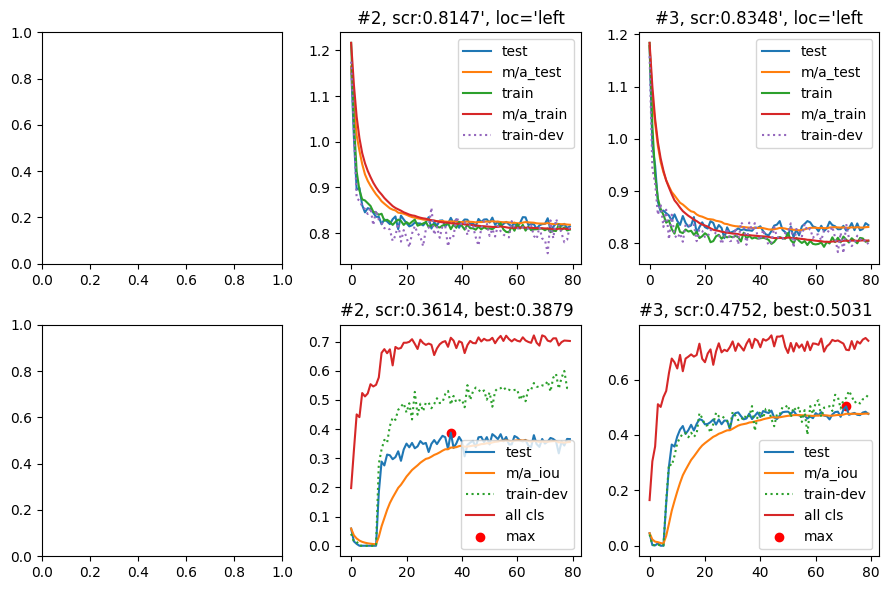

In [8]:
wsi_list = [1,2,3,4]

fig, axs = plt.subplots(2, len(wsi_list), figsize=(9, 6), layout='tight')

BS = 5
N_EPOCHS = 80
LR = 1e-04
WD = 1e-04
GAMMA = 0.99

scores_best = []
scores_wsi = []

for WSI in wsi_list:
    T0 = datetime.now()
    train_loader, test_loader, train_dev_loader = init_dataloaders(WSI, BS)

    model = smp.Unet(encoder_name='mit_b4',
                     encoder_weights='imagenet',
                     decoder_channels=(512, 256, 128, 64, 32),
                     decoder_use_batchnorm=True,
                     classes=3,
                     activation=None)

    model.segmentation_head[2] = nn.Softmax(dim=1)

    # weights = torch.tensor([0.1, 1, 1]).to(device)

    loss_func_dice = smp.losses.DiceLoss(mode='multiclass')
    # loss_func = nn.CrossEntropyLoss(weight=weights)
    loss_func_focal = smp.losses.FocalLoss(mode='multiclass')
    # loss_func = torchvision.ops.focal_loss()

    train_results = train_model(model, loss_func_focal, loss_func_dice, N_EPOCHS, LR, WD, GAMMA, WSI)

    iou_score = test_model(model, loss_func_focal, loss_func_dice)[1]

    scores_wsi.append(iou_score)
    scores_best.append(train_results['best_score'])

    axs[0, WSI-1] = axis_loss_set(axs[0, WSI-1], train_results)
    axs[1, WSI-1] = axis_iou_set(axs[1, WSI-1], train_results, iou_score)

    T1 = datetime.now() - T0

    print(f"WSI #{WSI} finished, Time elapsed: {T1}")
    print(f"Best score: {train_results['best_score']:.4f}, model score: {iou_score:.4f}")

mean_score = np.mean(scores_wsi)

fig.suptitle(f'CV={mean_score:.5f}, lr={LR}')
fig.savefig('res_figure.png', dpi=200)